# breast-cancer-detection-using-cnn

## Nitish Kumar

In [1]:
!pip install tensorflow

In [2]:
!pip install opencv-python

In [3]:
#importing necissary libraries

from numpy.random import seed
seed(101)

import pandas as pd
import numpy as np

import tensorflow

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import os
from os import listdir
import cv2

import imageio
import skimage
import skimage.io
import skimage.transform

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from skimage.io import imread
import itertools
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Exploring the Data Structure

In [17]:
files = listdir("../input/data/")
print(len(files))

1


In [18]:
#looking at first 10 folders
files[0:1]

['8863']

#### In each folder there are several images and each folder name is the id of the patient

In [20]:
base_path = "../input/data/"
folder = listdir(base_path)
print("No. of Patients:",len(folder))

No. of Patients: 1


#### We have to find the number of total images in the dataset

In [21]:
total_images = 0
for n in range(len(folder)):
    patient_id = folder[n]
    for c in [0, 1]:
        patient_path = base_path + patient_id
        class_path = patient_path + '/' + str(c) + '/'
        subfiles = listdir(class_path)
        total_images += len(subfiles)
        
print("Total Images in dataset: ", total_images )

Total Images in dataset:  979


#### Organizing the data into pandas data frame

In [22]:
data = pd.DataFrame(index=np.arange(0, total_images), columns=["patient_id", "path", "target"])

k = 0
for n in range(len(folder)):
    patient_id = folder[n]
    patient_path = base_path + patient_id 
    for c in [0,1]:
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        for m in range(len(subfiles)):
            image_path = subfiles[m]
            data.iloc[k]["path"] = class_path + image_path
            data.iloc[k]["target"] = c
            data.iloc[k]["patient_id"] = patient_id
            k += 1  

data.head()

,patient_id,path,target
0,8863,../input/data/8863/0/8863_idx5_x1001_y1001_cla...,0
1,8863,../input/data/8863/0/8863_idx5_x1001_y1051_cla...,0
2,8863,../input/data/8863/0/8863_idx5_x1001_y1101_cla...,0
3,8863,../input/data/8863/0/8863_idx5_x1001_y1151_cla...,0
4,8863,../input/data/8863/0/8863_idx5_x1001_y1201_cla...,0


#### Shape of data frame[](http://)

In [23]:
data.shape

(979, 3)

## Exploring the data

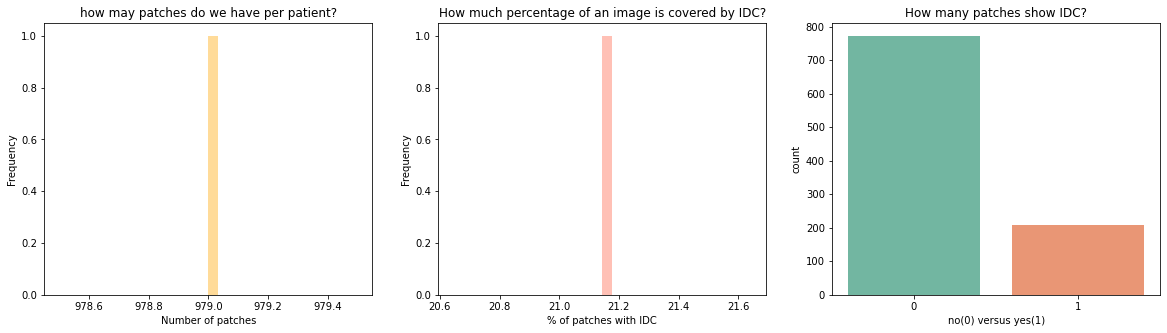

In [24]:
cancer_perc = data.groupby("patient_id").target.value_counts() / data.groupby("patient_id").target.size()
canxer_perc = cancer_perc.unstack()

fig, ax = plt.subplots(1, 3,figsize = (20,5))
sns.distplot(data.groupby('patient_id').size(), ax=ax[0], color='Orange', kde=False, bins=30)
ax[0].set_xlabel('Number of patches')
ax[0].set_ylabel('Frequency')
ax[0].set_title('how may patches do we have per patient?')
sns.distplot(cancer_perc.loc[:, 1]*100, ax=ax[1], color="Tomato", kde=False, bins=30)
ax[1].set_title("How much percentage of an image is covered by IDC?")
ax[1].set_ylabel("Frequency")
ax[1].set_xlabel("% of patches with IDC");
sns.countplot(data.target, palette="Set2", ax=ax[2]);
ax[2].set_xlabel("no(0) versus yes(1)")
ax[2].set_title("How many patches show IDC?");


### Insights

* The numbe rof image patches per patient varie's a lot.

* Some patients have more than 80 % patches that show IDC! Consequently the tissue is full of cancer or only a part of the breast was covered by the tissue slice that is focused on the IDC cancer. 

* The classes of IDC versus no IDC are imbalanced.

In [25]:
# coverting target to int
data.target = data.target.astype(np.int)

<ipython-input-25-8a57bb4045d9>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data.target = data.target.astype(np.int)


### Displaying Cnacer Tissue Samples

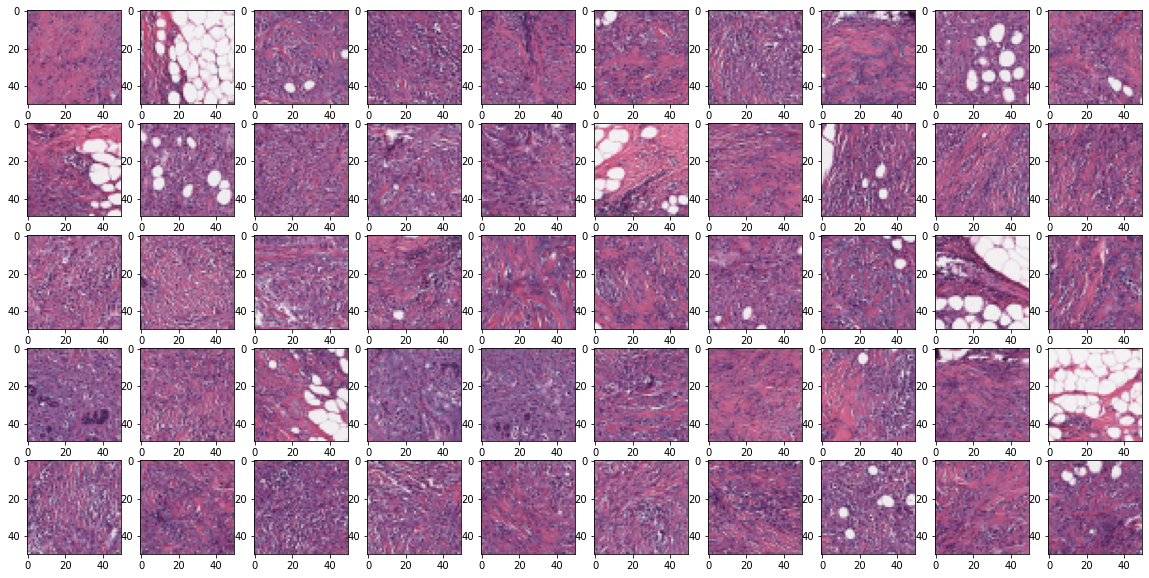

In [26]:
cancer_selection = np.random.choice(data[data.target == 1].index.values, size=50, replace=False)

fig, ax = plt.subplots(5, 10, figsize=(20, 10))

for n in range(5):
    for m in range(10):
        idx = cancer_selection[m + 10*n]
        image = imread(data.loc[idx, "path"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)


### Displaying Non-Cnacer Tissue Samples

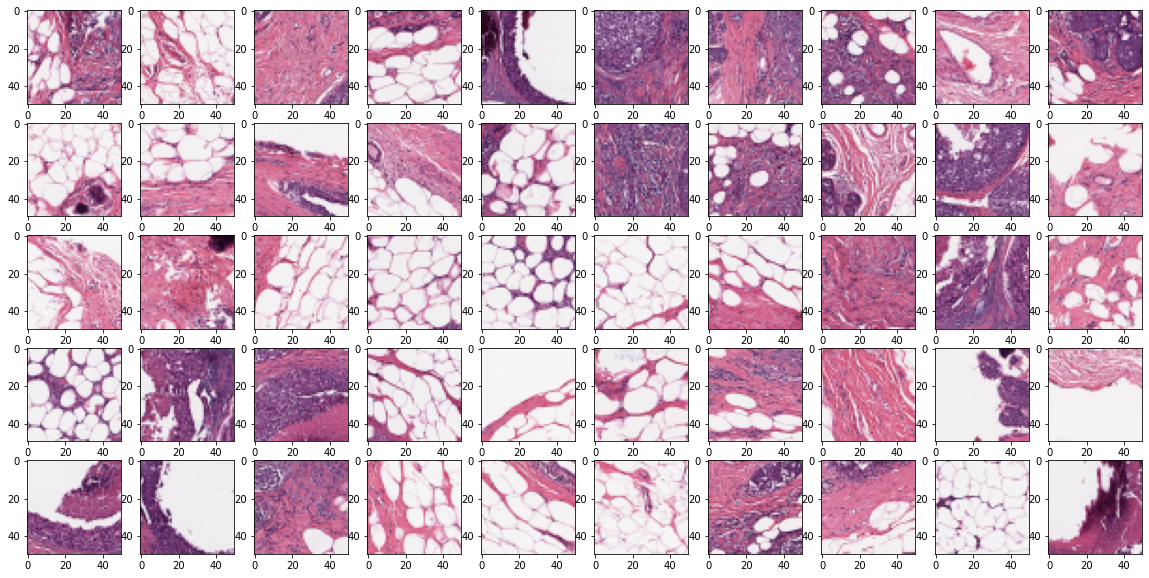

In [27]:
non_cancer_selection = np.random.choice(data[data.target == 0].index.values, size=50, replace=False)

fig, ax = plt.subplots(5, 10, figsize=(20, 10))

for n in range(5):
    for m in range(10):
        idx = non_cancer_selection[m + 10*n]
        image = imread(data.loc[idx, "path"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

### Insights

* Cancer Tissur appears to be more viloet.

* But some non-caner tissue is also violet.


## Preparing the dataset

In [28]:
# Creating diresctory to store all images
all_images_dir = 'all_images_dir'

if os.path.isdir(all_images_dir):
    pass
else:
    os.mkdir(all_images_dir)
    


In [30]:
# This code copies all images from their seperate folders into the same 
# folder called all_images_dir.

'''
The directory structure is like:
    patient_id:
                0
                1
'''

patient_list = folder

for patient in patient_list:
    
    path_0 = "../input/data/" + str(patient) + '/0'
    path_1 = "../input/data/" + str(patient) + '/1'
    
    # create list of all files in folder 0
    file_list_0 = listdir(path_0)
    
    #create a list of all files in folder 1
    file_list_1 = listdir(path_1)
    
    # moving the 0 class images to all_images_dir
    for fname in file_list_0:
        
        src = os.path.join(path_0, fname)
        dst = os.path.join(all_images_dir, fname)
        shutil.copyfile(src, dst)
        
    # moving the 1 class images to all_images_dir
    for fname in file_list_1:
        
        src = os.path.join(path_1, fname)
        dst = os.path.join(all_images_dir, fname)
        shutil.copyfile(src, dst)
        
    
        

In [31]:
# Total number of images
len(listdir(all_images_dir))

979

### Creating dataframe of all images

In [32]:
image_list = os.listdir('all_images_dir')
df_data = pd.DataFrame(image_list, columns=['image_id'])

df_data.head()

,image_id
0,8863_idx5_x1001_y1001_class0.png
1,8863_idx5_x1001_y1051_class0.png
2,8863_idx5_x1001_y1101_class0.png
3,8863_idx5_x1001_y1151_class0.png
4,8863_idx5_x1001_y1201_class0.png


In [33]:
# Defining helper functions

def extract_patient_id(x):
    
    a = x.split('_')
    patient_id = a[0]
    
    return patient_id

def extract_target(x):
    
    a = x.split('_')
    b = a[4]
    target = b[5]
    
    return target

# creating new column named patient_id
df_data['patient_id'] = df_data['image_id'].apply(extract_patient_id)

#creating new column named target
df_data['target'] = df_data['image_id'].apply(extract_target)

df_data.head(10)

    

,image_id,patient_id,target
0,8863_idx5_x1001_y1001_class0.png,8863,0
1,8863_idx5_x1001_y1051_class0.png,8863,0
2,8863_idx5_x1001_y1101_class0.png,8863,0
3,8863_idx5_x1001_y1151_class0.png,8863,0
4,8863_idx5_x1001_y1201_class0.png,8863,0
5,8863_idx5_x1001_y1251_class0.png,8863,0
6,8863_idx5_x1001_y1301_class0.png,8863,0
7,8863_idx5_x1001_y1351_class0.png,8863,0
8,8863_idx5_x1001_y1401_class0.png,8863,0
9,8863_idx5_x1001_y1451_class0.png,8863,0


In [34]:
# class distribution of the images

df_data['target'].value_counts()

0    772
1    207
Name: target, dtype: int64

### Balance the class distribution

* We can see that the class 1 images are higher in number that of class 0

* So to prevent this we balance the dataset

* We do this so that the Neural Network dose not lean on favouring only one class 

In [35]:
SAMPLE_SIZE = 207

# take a sample of the majority class 0 (total = 198738)
df_0 = df_data[df_data['target'] == '0'].sample(SAMPLE_SIZE, random_state=101)
# take a sample of class 1 (total = 207)
df_1 = df_data[df_data['target'] == '1'].sample(SAMPLE_SIZE, random_state=101)

# concat the two dataframes
df_data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)

# Check the new class distribution
df_data['target'].value_counts()

1    207
0    207
Name: target, dtype: int64

### Creating train and test sets

In [36]:
y = df_data['target']

df_train, df_val = train_test_split(df_data, test_size=0.10, random_state=101, stratify=y)

print(df_train.shape)
print(df_val.shape)

(372, 3)
(42, 3)


### Creating Directory Structure

In [37]:
# Creating new base directory
base_dir ='base_dir'
os.mkdir(base_dir)

# Creating train directory inside base directory
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# Creating validation directory inside base directory
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)

# create new folders inside train_dir
a_no_idc = os.path.join(train_dir, 'a_no_idc')
os.mkdir(a_no_idc)
b_has_idc = os.path.join(train_dir, 'b_has_idc')
os.mkdir(b_has_idc)


# create new folders inside val_dir
a_no_idc = os.path.join(val_dir, 'a_no_idc')
os.mkdir(a_no_idc)
b_has_idc = os.path.join(val_dir, 'b_has_idc')
os.mkdir(b_has_idc)




In [38]:
# check that the folders have been created
os.listdir('base_dir/train_dir')

['a_no_idc', 'b_has_idc']

In [39]:
# Set the id as the index in df_data
df_data.set_index('image_id', inplace=True)

In [40]:
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])

# Transfering the train images
for image in train_list:

    try: 
        fname = image
        target = df_data.loc[image, 'target']

        if target == '0':
            label = 'a_no_idc'
        if target == '1':
            label = 'b_has_idc'

        # source path to image
        src = os.path.join(all_images_dir, fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # move the image from the source to the destination
        shutil.move(src, dst)
    except: 
        continue

for image in val_list:

    try: 
        fname = image
        target = df_data.loc[image,'target']

        if target == '0':
            label = 'a_no_idc'
        if target == '1':
            label = 'b_has_idc'


        # source path to image
        src = os.path.join(all_images_dir, fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # move the image from the source to the destination
        shutil.move(src, dst)

    except:
        continue

        

In [41]:
# check how many val images we have in each folder
print(len(os.listdir('base_dir/train_dir/a_no_idc')))
print(len(os.listdir('base_dir/train_dir/b_has_idc')))

186
186


### Setting up image generators

In [42]:
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [43]:
IMAGE_SIZE = 50

In [44]:

datagen = ImageDataGenerator(rescale = 1.0 / 255,
                             rotation_range = 90,
                             zoom_range = 0.2,
                             horizontal_flip=True,
                             vertical_flip=True)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')

# Note: shuffle=False causes the test dataset to not be shuffled
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

Found 372 images belonging to 2 classes.
Found 42 images belonging to 2 classes.
Found 42 images belonging to 2 classes.


In [45]:
# Building the model
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3


model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', 
                 input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(2, activation = "softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 32)        9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 44, 44, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 22, 22, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 22, 22, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 20, 20, 64)        18496     
                                                        

### Training the model

In [46]:
model.compile(Adam(lr=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy'])

In [47]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=3, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=50, verbose=1,
                   callbacks=callbacks_list)

try:
    model.save('/kaggle/working/model.h5')
except:
    pass

try:
    model.save('model.h5')
except:
    pass

<ipython-input-47-8d6535370f1e>:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen, steps_per_epoch=train_steps,


Epoch 1/50
38/38 [==============================] - ETA: 0s - loss: 0.6840 - accuracy: 0.5484WARNING:tensorflow:Can save best model only with val_acc available, skipping.


38/38 [==============================] - 15s 212ms/step - loss: 0.6840 - accuracy: 0.5484 - val_loss: 0.6937 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/50
38/38 [==============================] - ETA: 0s - loss: 0.6750 - accuracy: 0.5538WARNING:tensorflow:Can save best model only with val_acc available, skipping.


38/38 [==============================] - 6s 156ms/step - loss: 0.6750 - accuracy: 0.5538 - val_loss: 0.6094 - val_accuracy: 0.6905 - lr: 0.0010
Epoch 3/50
38/38 [==============================] - ETA: 0s - loss: 0.6918 - accuracy: 0.5081WARNING:tensorflow:Can save best model only with val_acc available, skipping.


38/38 [==============================] - 6s 153ms/step - loss: 0.6918 - accuracy: 0.5081 - val_loss: 0.6942 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/50
38/38 [==============================] - ETA: 0s - loss: 0.6939 - accuracy: 0.5000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


38/38 [==============================] - 6s 157ms/step - loss: 0.6939 - accuracy: 0.5000 - val_loss: 0.6917 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 5/50
38/38 [==============================] - ETA: 0s - loss: 0.6818 - accuracy: 0.5538WARNING:tensorflow:Can save best model only with val_acc available, skipping.


38/38 [==============================] - 6s 160ms/step - loss: 0.6818 - accuracy: 0.5538 - val_loss: 0.6305 - val_accuracy: 0.8095 - lr: 0.0010
Epoch 6/50
38/38 [==============================] - ETA: 0s - loss: 0.6680 - accuracy: 0.5376WARNING:tensorflow:Can save best model only with val_acc available, skipping.


38/38 [==============================] - 6s 155ms/step - loss: 0.6680 - accuracy: 0.5376 - val_loss: 0.6944 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 7/50
38/38 [==============================] - ETA: 0s - loss: 0.6872 - accuracy: 0.5511WARNING:tensorflow:Can save best model only with val_acc available, skipping.


38/38 [==============================] - 6s 158ms/step - loss: 0.6872 - accuracy: 0.5511 - val_loss: 0.6704 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 8/50
38/38 [==============================] - ETA: 0s - loss: 0.6855 - accuracy: 0.5188WARNING:tensorflow:Can save best model only with val_acc available, skipping.


38/38 [==============================] - 6s 158ms/step - loss: 0.6855 - accuracy: 0.5188 - val_loss: 0.6966 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 9/50
38/38 [==============================] - ETA: 0s - loss: 0.6957 - accuracy: 0.5000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


38/38 [==============================] - 6s 153ms/step - loss: 0.6957 - accuracy: 0.5000 - val_loss: 0.6937 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 10/50
38/38 [==============================] - ETA: 0s - loss: 0.6938 - accuracy: 0.5000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


38/38 [==============================] - 6s 154ms/step - loss: 0.6938 - accuracy: 0.5000 - val_loss: 0.6935 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 11/50
38/38 [==============================] - ETA: 0s - loss: 0.6942 - accuracy: 0.4973WARNING:tensorflow:Can save best model only with val_acc available, skipping.


38/38 [==============================] - 6s 150ms/step - loss: 0.6942 - accuracy: 0.4973 - val_loss: 0.6932 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 12/50
38/38 [==============================] - ETA: 0s - loss: 0.6939 - accuracy: 0.4543WARNING:tensorflow:Can save best model only with val_acc available, skipping.


38/38 [==============================] - 6s 152ms/step - loss: 0.6939 - accuracy: 0.4543 - val_loss: 0.6931 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 13/50
38/38 [==============================] - ETA: 0s - loss: 0.6936 - accuracy: 0.5027WARNING:tensorflow:Can save best model only with val_acc available, skipping.


38/38 [==============================] - 6s 153ms/step - loss: 0.6936 - accuracy: 0.5027 - val_loss: 0.6932 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 14/50
38/38 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5027WARNING:tensorflow:Can save best model only with val_acc available, skipping.


38/38 [==============================] - 6s 151ms/step - loss: 0.6932 - accuracy: 0.5027 - val_loss: 0.6931 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 15/50
38/38 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5242WARNING:tensorflow:Can save best model only with val_acc available, skipping.


38/38 [==============================] - 6s 160ms/step - loss: 0.6932 - accuracy: 0.5242 - val_loss: 0.6933 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 16/50
38/38 [==============================] - ETA: 0s - loss: 0.6939 - accuracy: 0.4731WARNING:tensorflow:Can save best model only with val_acc available, skipping.


38/38 [==============================] - 6s 158ms/step - loss: 0.6939 - accuracy: 0.4731 - val_loss: 0.6932 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 17/50
38/38 [==============================] - ETA: 0s - loss: 0.6939 - accuracy: 0.4435WARNING:tensorflow:Can save best model only with val_acc available, skipping.


38/38 [==============================] - 6s 154ms/step - loss: 0.6939 - accuracy: 0.4435 - val_loss: 0.6932 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 18/50
38/38 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5027WARNING:tensorflow:Can save best model only with val_acc available, skipping.


38/38 [==============================] - 6s 153ms/step - loss: 0.6932 - accuracy: 0.5027 - val_loss: 0.6931 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 19/50
38/38 [==============================] - ETA: 0s - loss: 0.6938 - accuracy: 0.4624WARNING:tensorflow:Can save best model only with val_acc available, skipping.


38/38 [==============================] - 6s 152ms/step - loss: 0.6938 - accuracy: 0.4624 - val_loss: 0.6932 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 20/50
38/38 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


38/38 [==============================] - 6s 150ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 21/50
38/38 [==============================] - ETA: 0s - loss: 0.6937 - accuracy: 0.4866WARNING:tensorflow:Can save best model only with val_acc available, skipping.


38/38 [==============================] - 6s 153ms/step - loss: 0.6937 - accuracy: 0.4866 - val_loss: 0.6932 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 22/50
38/38 [==============================] - ETA: 0s - loss: 0.6939 - accuracy: 0.4543WARNING:tensorflow:Can save best model only with val_acc available, skipping.


38/38 [==============================] - 6s 152ms/step - loss: 0.6939 - accuracy: 0.4543 - val_loss: 0.6932 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 23/50
38/38 [==============================] - ETA: 0s - loss: 0.6935 - accuracy: 0.5108WARNING:tensorflow:Can save best model only with val_acc available, skipping.


38/38 [==============================] - 6s 157ms/step - loss: 0.6935 - accuracy: 0.5108 - val_loss: 0.6932 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 24/50
38/38 [==============================] - ETA: 0s - loss: 0.6938 - accuracy: 0.4973WARNING:tensorflow:Can save best model only with val_acc available, skipping.


38/38 [==============================] - 6s 153ms/step - loss: 0.6938 - accuracy: 0.4973 - val_loss: 0.6932 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 25/50
38/38 [==============================] - ETA: 0s - loss: 0.6930 - accuracy: 0.4839WARNING:tensorflow:Can save best model only with val_acc available, skipping.


38/38 [==============================] - 6s 152ms/step - loss: 0.6930 - accuracy: 0.4839 - val_loss: 0.6932 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 26/50
38/38 [==============================] - ETA: 0s - loss: 0.6936 - accuracy: 0.4919WARNING:tensorflow:Can save best model only with val_acc available, skipping.


38/38 [==============================] - 6s 152ms/step - loss: 0.6936 - accuracy: 0.4919 - val_loss: 0.6932 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 27/50
38/38 [==============================] - ETA: 0s - loss: 0.6936 - accuracy: 0.4866WARNING:tensorflow:Can save best model only with val_acc available, skipping.


38/38 [==============================] - 6s 152ms/step - loss: 0.6936 - accuracy: 0.4866 - val_loss: 0.6932 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 28/50
38/38 [==============================] - ETA: 0s - loss: 0.6938 - accuracy: 0.4919WARNING:tensorflow:Can save best model only with val_acc available, skipping.


38/38 [==============================] - 6s 157ms/step - loss: 0.6938 - accuracy: 0.4919 - val_loss: 0.6933 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 29/50
38/38 [==============================] - ETA: 0s - loss: 0.6936 - accuracy: 0.5027WARNING:tensorflow:Can save best model only with val_acc available, skipping.


38/38 [==============================] - 6s 152ms/step - loss: 0.6936 - accuracy: 0.5027 - val_loss: 0.6933 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 30/50
38/38 [==============================] - ETA: 0s - loss: 0.6933 - accuracy: 0.5081WARNING:tensorflow:Can save best model only with val_acc available, skipping.


38/38 [==============================] - 6s 153ms/step - loss: 0.6933 - accuracy: 0.5081 - val_loss: 0.6932 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 31/50
38/38 [==============================] - ETA: 0s - loss: 0.6938 - accuracy: 0.4731WARNING:tensorflow:Can save best model only with val_acc available, skipping.


38/38 [==============================] - 6s 151ms/step - loss: 0.6938 - accuracy: 0.4731 - val_loss: 0.6932 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 32/50
38/38 [==============================] - ETA: 0s - loss: 0.6934 - accuracy: 0.5054WARNING:tensorflow:Can save best model only with val_acc available, skipping.


38/38 [==============================] - 6s 153ms/step - loss: 0.6934 - accuracy: 0.5054 - val_loss: 0.6932 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 33/50
38/38 [==============================] - ETA: 0s - loss: 0.6936 - accuracy: 0.4624WARNING:tensorflow:Can save best model only with val_acc available, skipping.


38/38 [==============================] - 6s 149ms/step - loss: 0.6936 - accuracy: 0.4624 - val_loss: 0.6931 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 34/50
38/38 [==============================] - ETA: 0s - loss: 0.6939 - accuracy: 0.4570WARNING:tensorflow:Can save best model only with val_acc available, skipping.


38/38 [==============================] - 6s 148ms/step - loss: 0.6939 - accuracy: 0.4570 - val_loss: 0.6932 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 35/50
38/38 [==============================] - ETA: 0s - loss: 0.6936 - accuracy: 0.4946WARNING:tensorflow:Can save best model only with val_acc available, skipping.


38/38 [==============================] - 6s 152ms/step - loss: 0.6936 - accuracy: 0.4946 - val_loss: 0.6932 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 36/50
38/38 [==============================] - ETA: 0s - loss: 0.6933 - accuracy: 0.5027WARNING:tensorflow:Can save best model only with val_acc available, skipping.


38/38 [==============================] - 6s 157ms/step - loss: 0.6933 - accuracy: 0.5027 - val_loss: 0.6933 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 37/50
38/38 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


38/38 [==============================] - 6s 153ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 38/50
38/38 [==============================] - ETA: 0s - loss: 0.6930 - accuracy: 0.5027WARNING:tensorflow:Can save best model only with val_acc available, skipping.


38/38 [==============================] - 6s 166ms/step - loss: 0.6930 - accuracy: 0.5027 - val_loss: 0.6933 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 39/50
38/38 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


38/38 [==============================] - 6s 153ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6933 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 40/50
38/38 [==============================] - ETA: 0s - loss: 0.6934 - accuracy: 0.4973WARNING:tensorflow:Can save best model only with val_acc available, skipping.


38/38 [==============================] - 6s 154ms/step - loss: 0.6934 - accuracy: 0.4973 - val_loss: 0.6932 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 41/50
38/38 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5081WARNING:tensorflow:Can save best model only with val_acc available, skipping.


38/38 [==============================] - 6s 149ms/step - loss: 0.6931 - accuracy: 0.5081 - val_loss: 0.6932 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 42/50
38/38 [==============================] - ETA: 0s - loss: 0.6936 - accuracy: 0.4892WARNING:tensorflow:Can save best model only with val_acc available, skipping.


38/38 [==============================] - 6s 151ms/step - loss: 0.6936 - accuracy: 0.4892 - val_loss: 0.6933 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 43/50
38/38 [==============================] - ETA: 0s - loss: 0.6929 - accuracy: 0.5027WARNING:tensorflow:Can save best model only with val_acc available, skipping.


38/38 [==============================] - 6s 149ms/step - loss: 0.6929 - accuracy: 0.5027 - val_loss: 0.6932 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 44/50
38/38 [==============================] - ETA: 0s - loss: 0.6933 - accuracy: 0.4919WARNING:tensorflow:Can save best model only with val_acc available, skipping.


38/38 [==============================] - 6s 151ms/step - loss: 0.6933 - accuracy: 0.4919 - val_loss: 0.6932 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 45/50
38/38 [==============================] - ETA: 0s - loss: 0.6938 - accuracy: 0.4946WARNING:tensorflow:Can save best model only with val_acc available, skipping.


38/38 [==============================] - 6s 153ms/step - loss: 0.6938 - accuracy: 0.4946 - val_loss: 0.6932 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 46/50
38/38 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.4946WARNING:tensorflow:Can save best model only with val_acc available, skipping.


38/38 [==============================] - 6s 156ms/step - loss: 0.6931 - accuracy: 0.4946 - val_loss: 0.6932 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 47/50
38/38 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.4919WARNING:tensorflow:Can save best model only with val_acc available, skipping.


38/38 [==============================] - 6s 153ms/step - loss: 0.6931 - accuracy: 0.4919 - val_loss: 0.6932 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 48/50
38/38 [==============================] - ETA: 0s - loss: 0.6935 - accuracy: 0.5027WARNING:tensorflow:Can save best model only with val_acc available, skipping.


38/38 [==============================] - 6s 170ms/step - loss: 0.6935 - accuracy: 0.5027 - val_loss: 0.6932 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 49/50
38/38 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.4892WARNING:tensorflow:Can save best model only with val_acc available, skipping.


38/38 [==============================] - 6s 161ms/step - loss: 0.6931 - accuracy: 0.4892 - val_loss: 0.6932 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 50/50
38/38 [==============================] - ETA: 0s - loss: 0.6938 - accuracy: 0.4704WARNING:tensorflow:Can save best model only with val_acc available, skipping.


38/38 [==============================] - 6s 157ms/step - loss: 0.6938 - accuracy: 0.4704 - val_loss: 0.6932 - val_accuracy: 0.5000 - lr: 0.0010


In [48]:
model.save('model.h5')

### Evaluating the model

In [49]:
# get the metric names so we can use evaulate_generator
model.metrics_names

['loss', 'accuracy']

In [50]:
# Here the best epoch will be used.

model.load_weights('model.h5')

val_loss, val_acc = \
model.evaluate_generator(test_gen, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_acc:', val_acc)

<ipython-input-50-28bf2f308882>:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(test_gen,


val_loss: 0.6931729316711426
val_acc: 0.5


### Plotting the training curves

<Figure size 432x288 with 0 Axes>

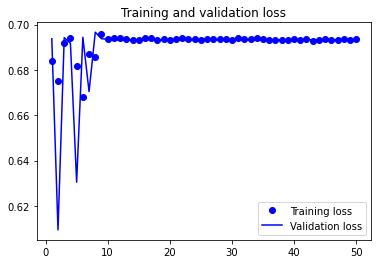

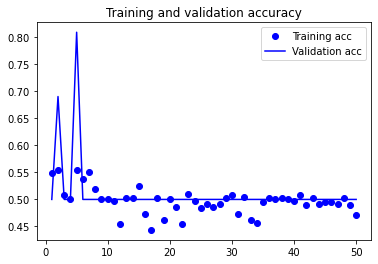

<Figure size 432x288 with 0 Axes>

In [51]:
# display the loss and accuracy curves

import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

### Make a prediction on the val set
We need these predictions to calculate the AUC score, print the Confusion Matrix and calculate the F1 score.

In [52]:
# make a prediction
predictions = model.predict_generator(test_gen, steps=len(df_val), verbose=1)

<ipython-input-52-94026f275592>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_gen, steps=len(df_val), verbose=1)


42/42 [==============================] - 1s 13ms/step


In [53]:
predictions.shape

(42, 2)

In [54]:
# This is how to check what index keras has internally assigned to each class. 
test_gen.class_indices

{'a_no_idc': 0, 'b_has_idc': 1}

In [55]:
# Put the predictions into a dataframe.
# The columns need to be oredered to match the output of the previous cell

df_preds = pd.DataFrame(predictions, columns=['no_idc', 'has_idc'])

df_preds.head()

,no_idc,has_idc
0,0.507115,0.492885
1,0.507115,0.492885
2,0.507115,0.492885
3,0.507115,0.492885
4,0.507115,0.492885


In [56]:
# Get the true labels
y_true = test_gen.classes

# Get the predicted labels as probabilities
y_pred = df_preds['has_idc']

### Calculating the AUC Score

In [57]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_true, y_pred)

0.5

### Creating the confusion matrix

In [58]:
def plot_confusion_matrix(cm, classes,
                         normalize=False,
                         title='Confusion Matrix',
                         cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
        

In [59]:
# Get the labels of the test images.

test_labels = test_gen.classes

In [60]:
test_labels.shape

(42,)

In [61]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [62]:
# Print the label associated with each class
test_gen.class_indices

{'a_no_idc': 0, 'b_has_idc': 1}

Confusion matrix, without normalization
[[21  0]
 [21  0]]


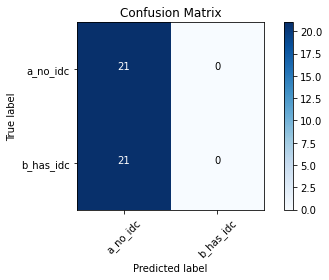

In [63]:
# Define the labels of the class indices. These need to match the 
# order shown above.
cm_plot_labels = ['a_no_idc', 'b_has_idc']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

### Creating a classfifcation Report

In [64]:
from sklearn.metrics import classification_report

# Generate a classification report

# For this to work we need y_pred as binary labels not as probabilities
y_pred_binary = predictions.argmax(axis=1)

report = classification_report(y_true, y_pred_binary, target_names=cm_plot_labels)

print(report)

              precision    recall  f1-score   support

    a_no_idc       0.50      1.00      0.67        21
   b_has_idc       0.00      0.00      0.00        21

    accuracy                           0.50        42
   macro avg       0.25      0.50      0.33        42
weighted avg       0.25      0.50      0.33        42



C:\Users\Subhash Kumar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Recall** = Given a class, will the classifier be able to detect it?<br>
**Precision** = Given a class prediction from a classifier, how likely is it to be correct?<br>
**F1 Score** = The harmonic mean of the recall and precision. Essentially, it punishes extreme values.

### Conclusion

* From the above report we can see that the model gives us admirable results.

* The model can be improved.

* The recall for each class should be ideally be above 0.90

* The present recall which the model produces is good enough.

* For use in the real world the recall can be further improved.

* This model can help pathologists detect cancer on tissue faster

* The manual examining of tissue slides would not be required